
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL

from teslakit.estela import Predictor

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL
from teslakit.util.time_operations import npdt64todatetime, fast_reindex_hourly, repair_times_hourly, add_max_storms_mask
   


In [2]:

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')

# --------------------------------------
# N, S, E profiles
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)


In [3]:
hist_Q_storms_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_N' + str(pN) + '.nc'))
hist_Q_storms_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_S' + str(pS) + '.nc'))
hist_Q_storms_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_E' + str(pE) + '.nc'))



In [4]:
hist_Q_wavesH= xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH.nc'))

hist_Q_wavesH_N = hist_Q_wavesH.sel(profile=pN)
hist_Q_wavesH_S = hist_Q_wavesH.sel(profile=pS)
hist_Q_wavesH_E = hist_Q_wavesH.sel(profile=pE)


### Plot

(730486.0, 730851.0)

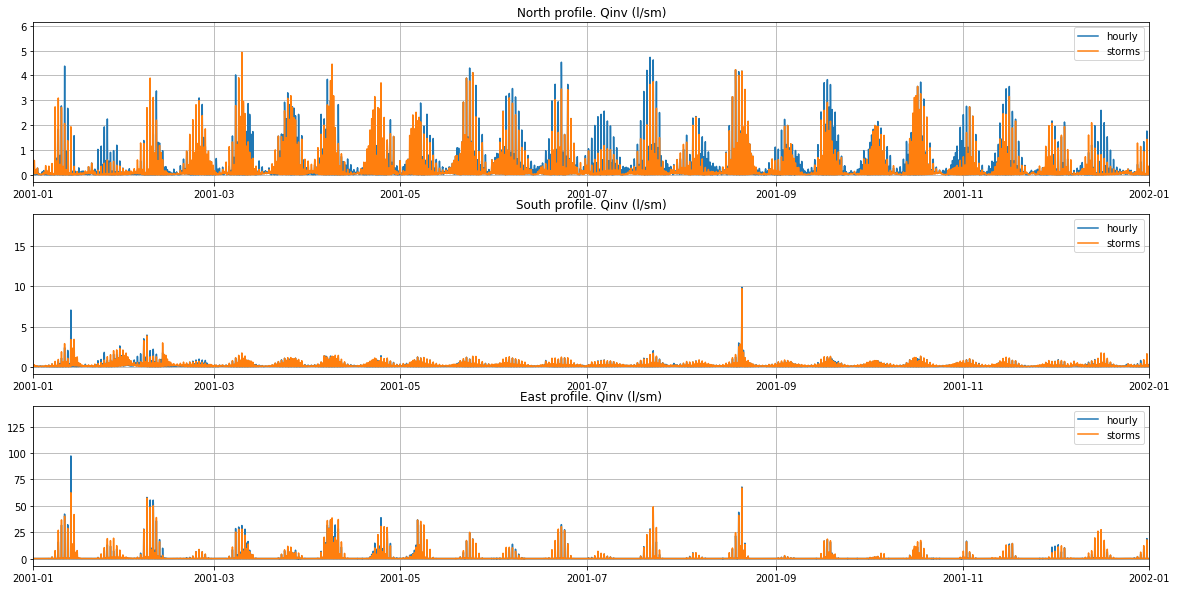

In [5]:

fig,axs = plt.subplots(3,1,figsize=(20,10))

axs[0].plot(hist_Q_wavesH_N.time, hist_Q_wavesH_N.Qinv.values, label='hourly')
axs[0].plot(hist_Q_storms_N.time, hist_Q_storms_N.Qinv.values, label='storms')
axs[0].legend()
axs[0].grid()
axs[0].title.set_text('North profile. Qinv (l/sm)')
axs[0].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

axs[1].plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.Qinv.values, label='hourly')
axs[1].plot(hist_Q_storms_S.time, hist_Q_storms_S.Qinv.values, label='storms')
axs[1].legend()
axs[1].grid()
axs[1].title.set_text('South profile. Qinv (l/sm)')
axs[1].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

axs[2].plot(hist_Q_wavesH_E.time, hist_Q_wavesH_E.Qinv.values, label='hourly')
axs[2].plot(hist_Q_storms_E.time, hist_Q_storms_E.Qinv.values, label='storms')
axs[2].legend()
axs[2].grid()
axs[2].title.set_text('East profile. Qinv (l/sm)')
axs[2].set_xlim(datetime(2001,1,1),datetime(2002,1,1))


Text(0.5, 1.0, 'South profile. Hs (m)')

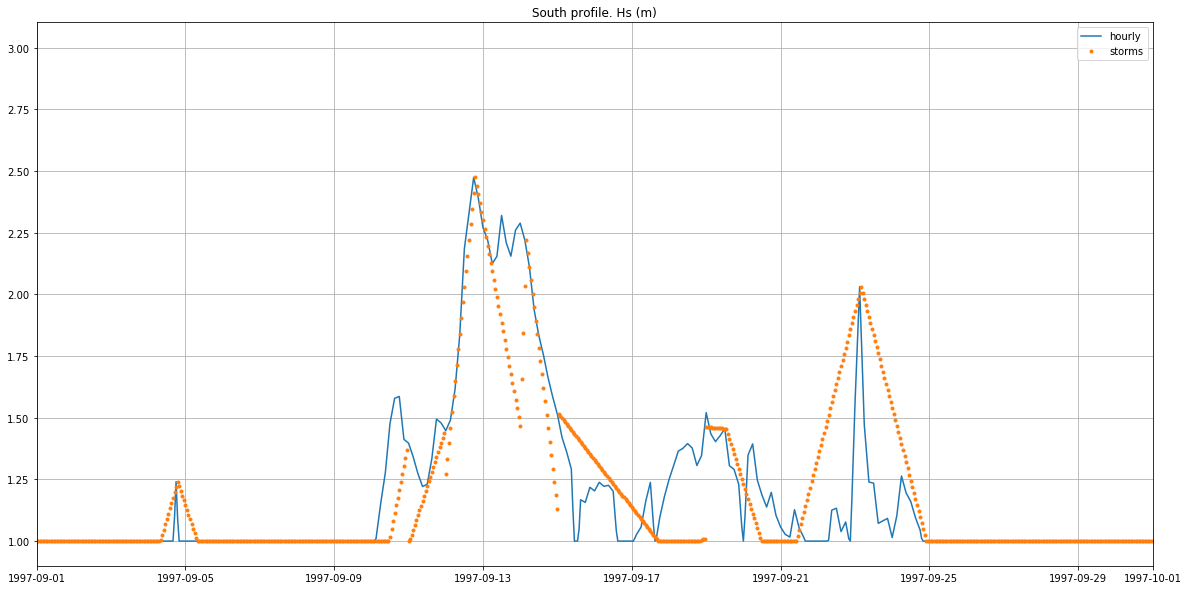

In [6]:

plt.figure(figsize=(20,10))

plt.plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.hs.values, label='hourly')
plt.plot(hist_Q_storms_S.time, hist_Q_storms_S.hs.values, '.',label='storms')



plt.xlim(datetime(1997,9,1),datetime(1997,10,1))
plt.legend()
plt.grid()
plt.title('South profile. Hs (m)')



Text(0.5, 1.0, 'South profile. Overtopping (l/s/m)')

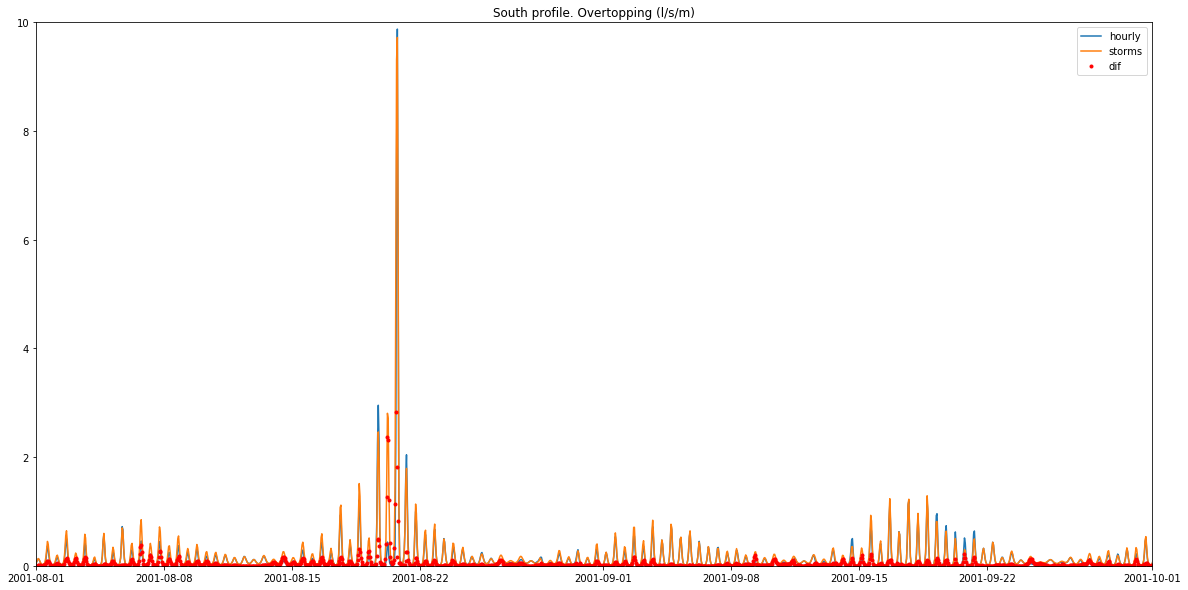

In [16]:
plt.figure(figsize=(20,10))

plt.plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.Qinv.values, label='hourly')
plt.plot(hist_Q_storms_S.time, hist_Q_storms_S.Qinv.values, label='storms')
plt.plot(hist_Q_storms_S.time, abs(hist_Q_wavesH_S.Qinv.values-hist_Q_storms_S.Qinv.values), '.r', label='dif')


plt.xlim(datetime(2001,8,1),datetime(2001,10,1))
plt.ylim(0,10)
plt.legend()
plt.title('South profile. Overtopping (l/s/m)')

Text(0.5, 1.0, 'East profile. Overtopping (l/s/m)')

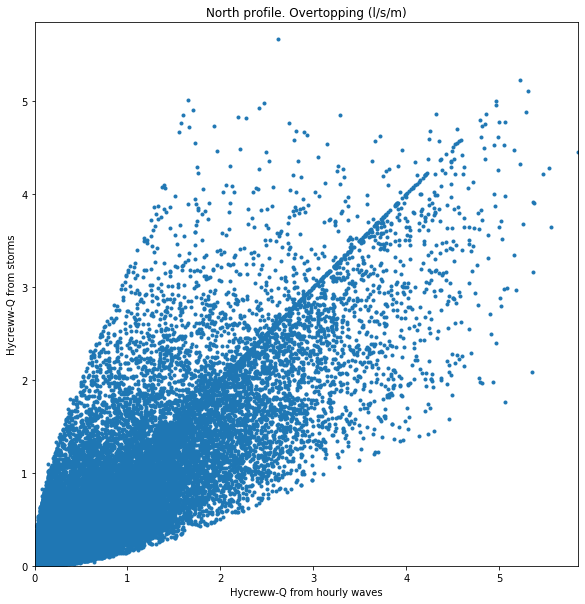

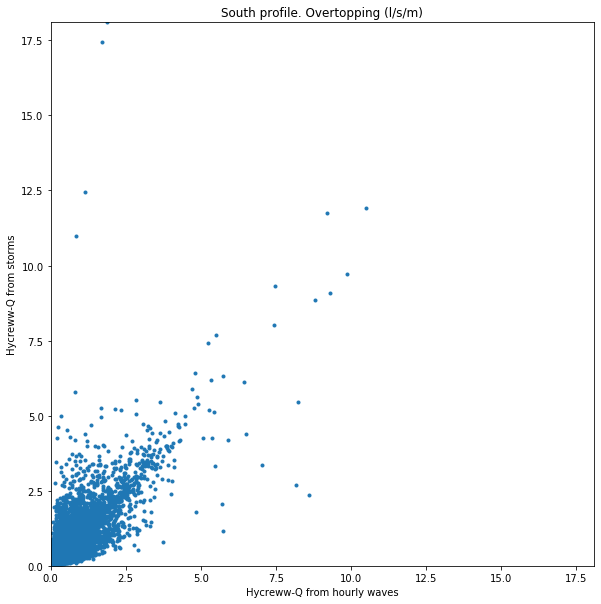

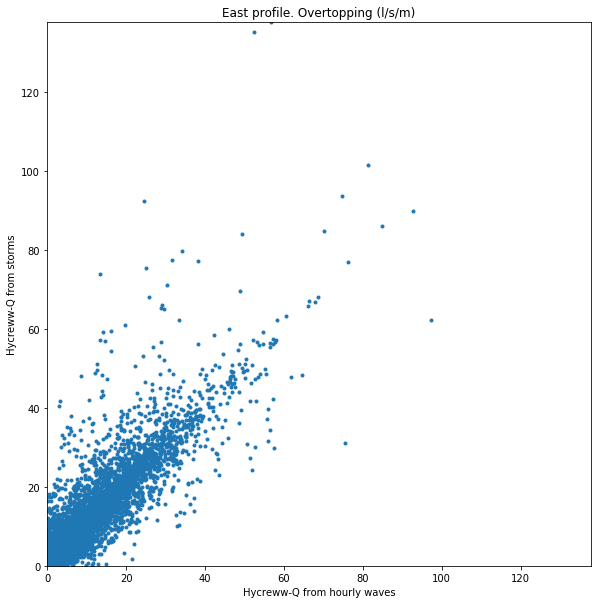

In [17]:
plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_N.Qinv.values), np.nanmax(hist_Q_storms_N.Qinv.values)])
plt.plot(hist_Q_wavesH_N.Qinv.values, hist_Q_storms_N.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('North profile. Overtopping (l/s/m)')


plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_S.Qinv.values), np.nanmax(hist_Q_storms_S.Qinv.values)])
plt.plot(hist_Q_wavesH_S.Qinv.values, hist_Q_storms_S.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('South profile. Overtopping (l/s/m)')

plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_E.Qinv.values), np.nanmax(hist_Q_storms_E.Qinv.values)])
plt.plot(hist_Q_wavesH_E.Qinv.values, hist_Q_storms_E.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('East profile. Overtopping (l/s/m)')